## How to recover a known planet in Kepler data?

In [14]:
import sys

In [15]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive("Kepler-10", quarter=3)

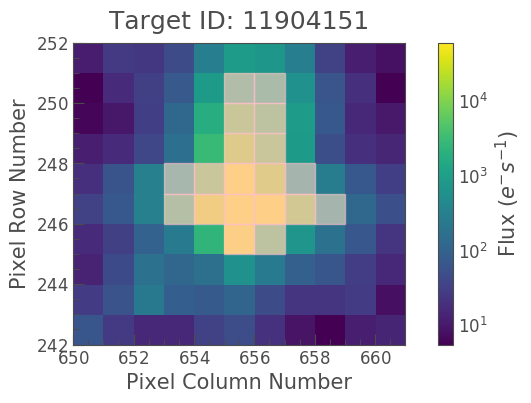

In [16]:
tpf.plot(scale='log', aperture_mask = tpf.pipeline_mask)

In [17]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

In [25]:
lc.to_pandas()[0:10]

,time,flux,flux_err,quality,centroid_col,centroid_row
time,,,,,,


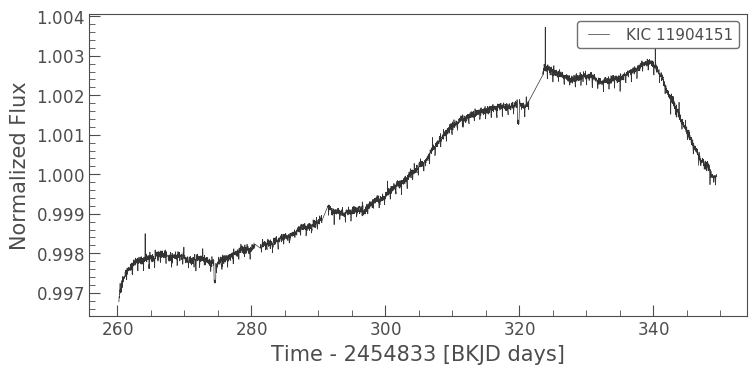

In [18]:
lc.plot()

In [6]:
flat, trend = lc.flatten(window_length=301, return_trend=True)

/usr/local/lib/python2.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


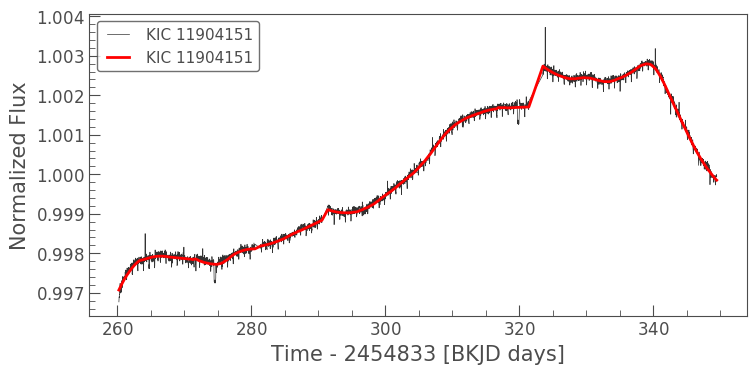

In [7]:
ax = lc.plot()
trend.plot(ax=ax, linewidth=2,color='red')

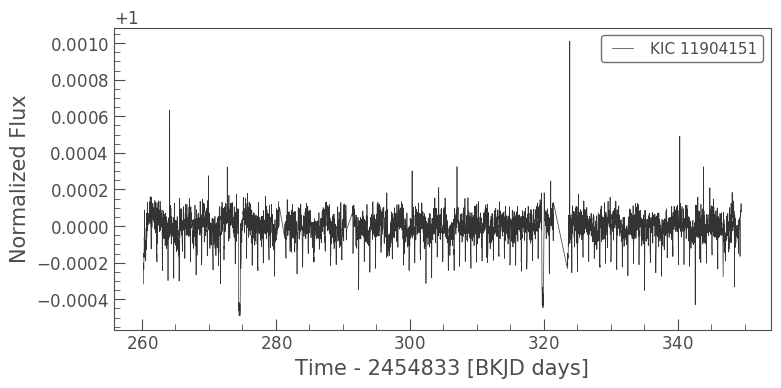

In [8]:
flat.plot()

In [9]:
from transit_periodogram import transit_periodogram
import numpy as np
import matplotlib.pyplot as plt

In [13]:
periods = np.arange(0.3, 1.5, 0.0001)
durations = np.arange(0.005, 0.15, 0.001)
power, _, _, _, _, _, _ = transit_periodogram(time = flat.time,
                                            flux = flat.flux,
                                            flux_err = flat.flux_err,
                                            periods=periods,
                                            durations=durations)
best_fit = periods[np.argmax(power)]

In [14]:
print('Best Fit Period: {} days'.format(best_fit))

Best Fit Period: 0.8375 days


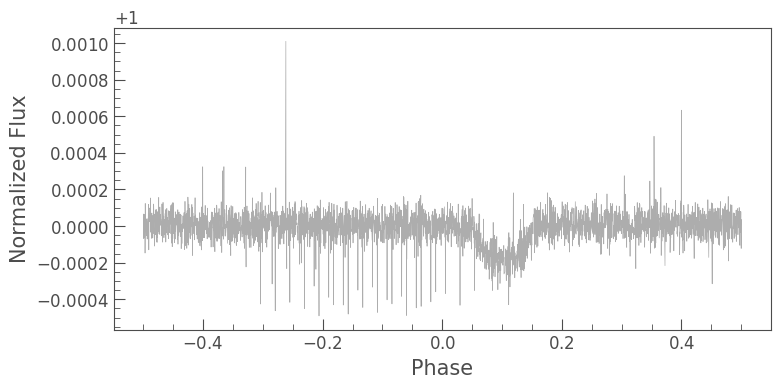

In [15]:
flat.fold(best_fit).plot(alpha=0.4)

 Noted issues:
 - Plots are not scatterplots
 - transit_periodogram has been depricated maybe?
 - In the plot function, need to define ax = ax

## How to use lightkurve for asteroseismology?

In [1]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import log
log.setLevel('ERROR')

In [2]:
ID = 211416749
tpf = KeplerTargetPixelFile.from_archive(ID, campaign=5, cadence='short')

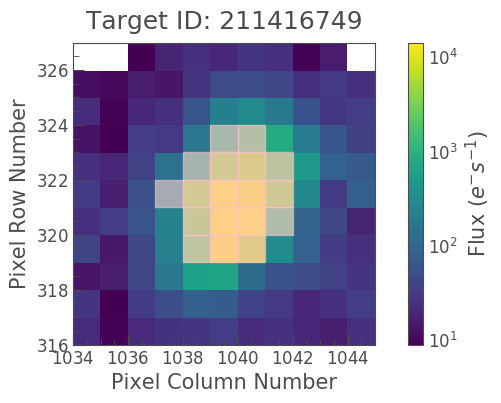

In [3]:
tpf.plot(scale='log', aperture_mask = tpf.pipeline_mask)

In [4]:
lc = tpf.to_lightcurve()
lc = lc.normalize().remove_nans().remove_outliers().fill_gaps()

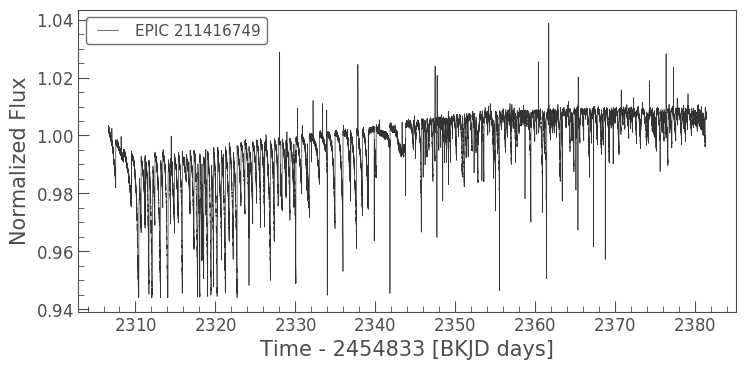

In [5]:
lc.plot()

In [6]:
p = lc.periodogram()

(0, 400)

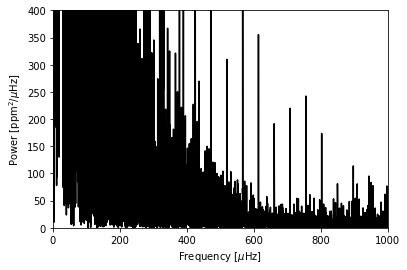

In [7]:
ax = p.plot(c='k')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 400)

In [8]:
lc = tpf.to_lightcurve().normalize().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()

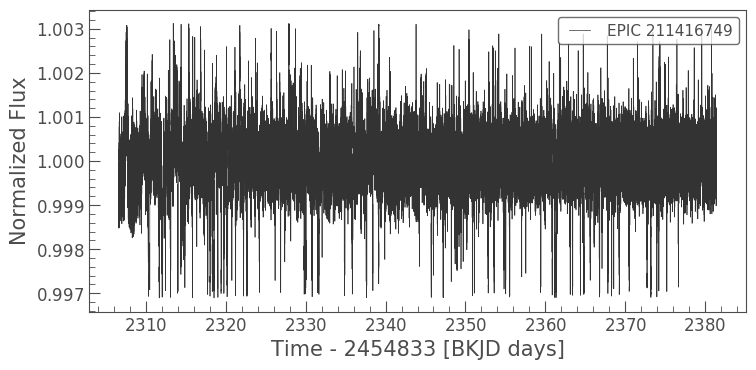

In [9]:
clc.plot()

(0, 50)

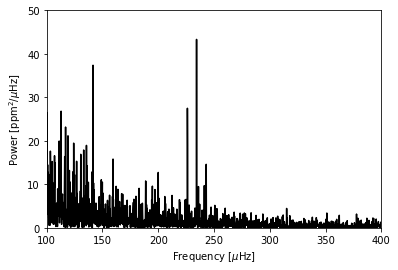

In [10]:
p_clean = clc.periodogram()
ax = p_clean.plot(c='k')
ax.set_xlim(100, 400)
ax.set_ylim(0, 50)


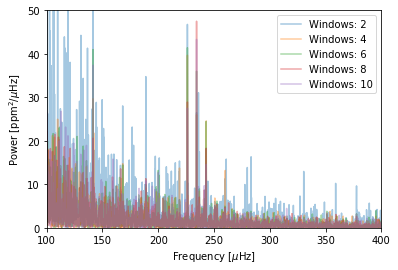

In [11]:
fig, ax = plt.subplots()
for windows in np.arange(2, 12, 2):
    lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
    clc = lc.correct(windows=windows).remove_outliers().fill_gaps()
    p_clean = clc.periodogram()
    p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))
ax.set_xlim(100, 400)
ax.set_ylim(0, 50)
ax.legend()

In [12]:
aper = np.nanmedian(tpf.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf.flux, axis=0), 70)


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Larger Aperture')

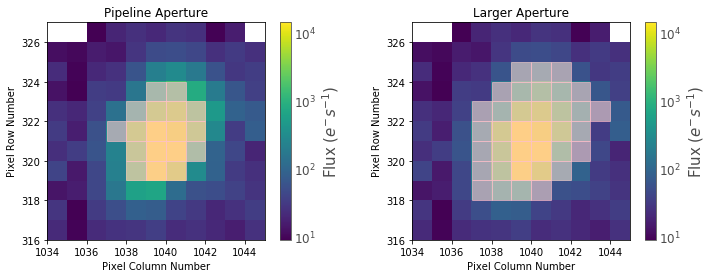

In [13]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=tpf.pipeline_mask)
axs[0].set_title('Pipeline Aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aper)
axs[1].set_title('Larger Aperture')

In [14]:
# Create the light curve with the pipelien aperture.
lc_pipeline = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
lc_pipeline = lc_pipeline.correct(windows=10).remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture
lc_larger_aperture = tpf.to_lightcurve(aperture_mask = aper).normalize().remove_nans().remove_outliers()
lc_larger_aperture = lc_larger_aperture.correct(windows=10).remove_outliers().fill_gaps()

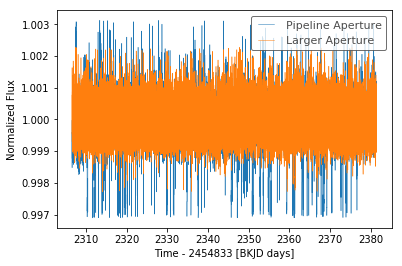

In [15]:
# Create subplots to plot into
fig, ax = plt.subplots()

#Plot the pipeline and large aperture light curves
lc_pipeline.plot(ax=ax, label='Pipeline Aperture')
lc_larger_aperture.plot(ax=ax, label='Larger Aperture')

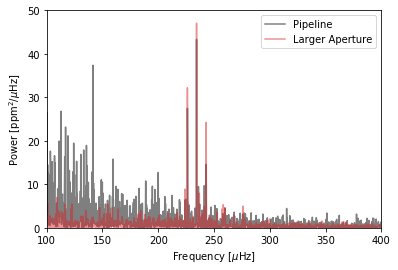

In [16]:
# Create the periodograms
p_pipeline = lc_pipeline.periodogram()
p_larger_aperture = lc_larger_aperture.periodogram()

# Create subplots to plot into
fig, ax = plt.subplots()
# Plot the periodograms
p_pipeline.plot(ax=ax, c='k', alpha=0.5, label='Pipeline')
p_larger_aperture.plot(ax=ax, c='C3', alpha=0.5, label='Larger Aperture')


ax.set_xlim(100, 400)
ax.set_ylim(0, 50)
ax.legend()

Notes:
- Takes a very long time to load in short cadence data (at least on my wifi)
- Do not get identical results to the tutorial?
- Some unexplained terms: CDPP?
- Direct code copied from the tutorial doesn't work anymore (aperture_mask = aper required)

## How to make a supernova lightcurve?

In [2]:
%matplotlib inline
import numpy as np
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(212593538, campaign=6)
tpf.shape

(3561, 8, 8)

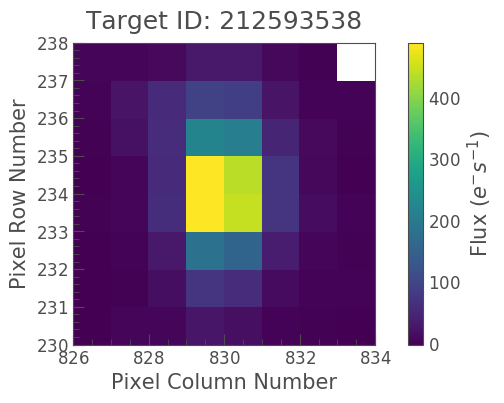

In [3]:
tpf.plot(frame=100)

In [4]:
postage_stamp_mask = tpf.hdu[2].data > 0
postage_stamp_mask.sum()

63

In [5]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


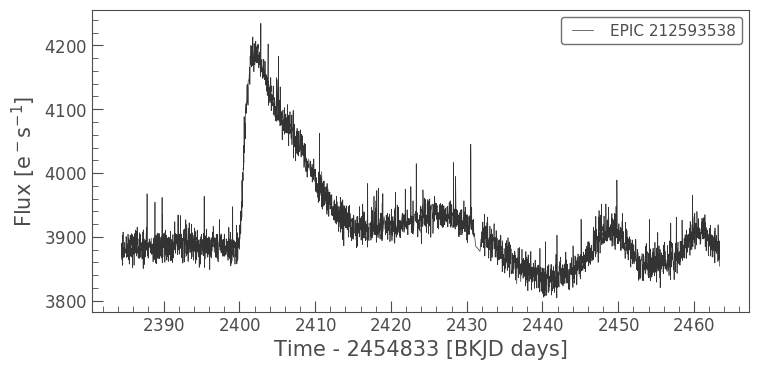

In [6]:
ax = lc_clean.plot(normalize=False)

In [10]:
tpf.interact(lc=lc_clean, notebook_url='localhost:8891')

The custom lightcurve provided to interact() does not contain the same number of cadences (3496) as the target pixel file (3561).
ERROR:lightkurve.interact:The custom lightcurve provided to interact() does not contain the same number of cadences (3496) as the target pixel file (3561).


In [7]:
aperture_mask = postage_stamp_mask.copy()
aperture_mask[:,-1] = False
aperture_mask[:,0] = False
background_mask = ~aperture_mask & postage_stamp_mask

In [8]:
N_targ_pixels, N_back_pixels = aperture_mask.sum(), background_mask.sum()
N_targ_pixels, N_back_pixels

(48, 15)

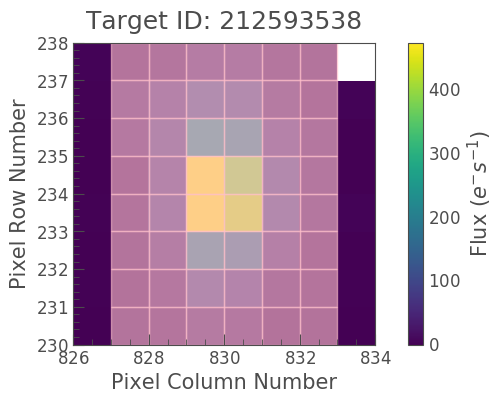

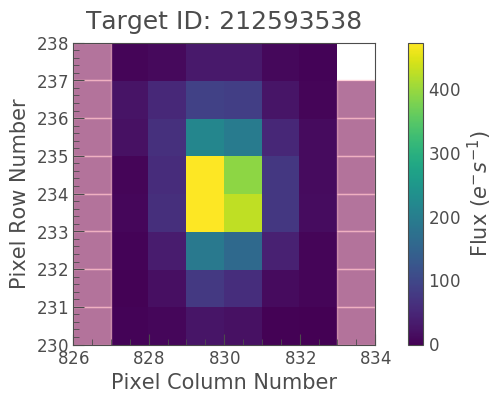

In [9]:
tpf.plot(aperture_mask=aperture_mask);
tpf.plot(aperture_mask=background_mask);

In [27]:
lc_aper = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc_back_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / N_back_pixels

In [28]:
lc_net = lc_aper - lc_back_per_pixel.flux * N_targ_pixels

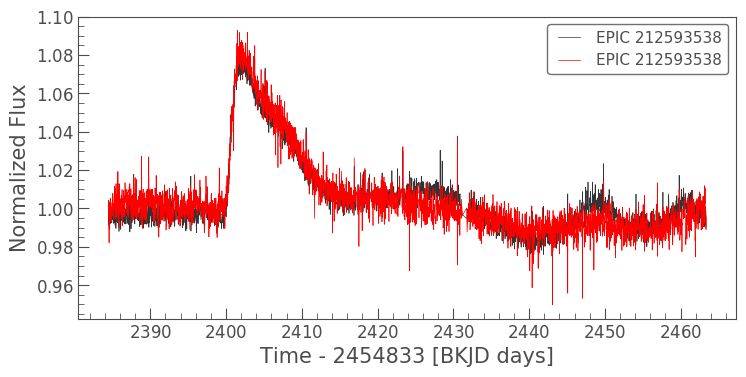

In [29]:
lc_net = lc_net[~spurious_cadences]
ax = lc_clean.plot()
lc_net.plot(ax=ax, color='red')

In [31]:
lc_corr = lc_net.correct(restore_trend=True)

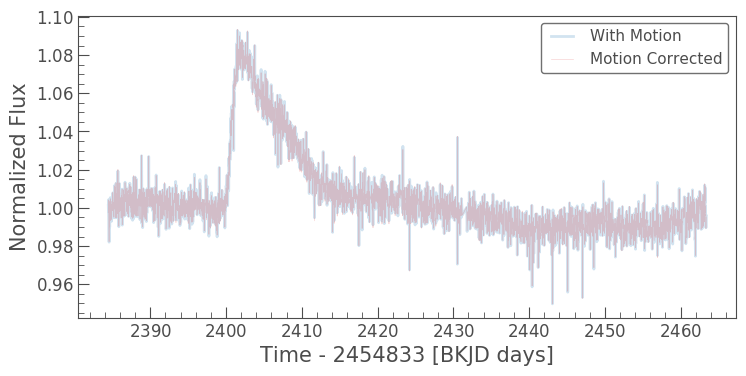

In [35]:
ax = lc_net.plot(color='C0', alpha=0.2, linewidth=2, label='With Motion')
ax = lc_corr.plot(ax=ax, color='C3', alpha=0.2, label='Motion Corrected');

Notes:
- A second observation has been made of KSN2015k since the tutorial was made, campaign should be specified to 6.
- tpf interact is commented out in the tutorial example
- tpf interact doesn't seem to work for me, but could be my machine
- tpf interact doesn't work with lc_clean because lc_clean has had frames removed, and so has fewer cadences than tpf
- None of the tqdm progress bars in the tutorials are in the code still?

## How to combine lightcurves from different Kepler quarters

In [36]:
from lightkurve import KeplerLightCurveFile
target = 'Kepler-8b'

In [41]:
lc = KeplerLightCurveFile.from_archive(target, quarter=1).PDCSAP_FLUX
from tqdm import tqdm
for q in tqdm(range(2, 17)):
    lc = lc.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX)

100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


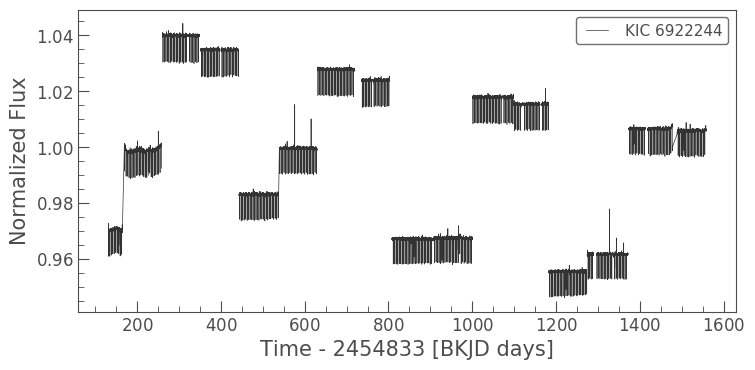

In [42]:
lc.plot()

In [43]:
lc = KeplerLightCurveFile.from_archive(target, quarter=1).PDCSAP_FLUX.normalize()
from tqdm import tqdm
for q in tqdm(range(2, 17)):
    lc = lc.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize())

100%|██████████| 15/15 [00:27<00:00,  1.80s/it]


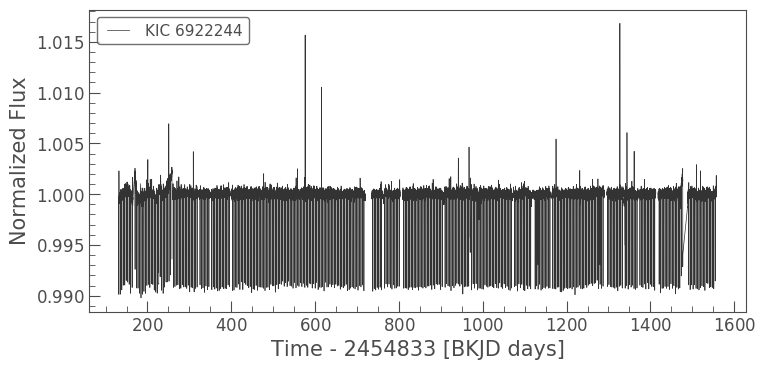

In [44]:
lc.plot()

In [56]:
lc = KeplerLightCurveFile.from_archive(target, quarter=1).PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,8):
    lc = lc.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize().flatten(window_length=401))

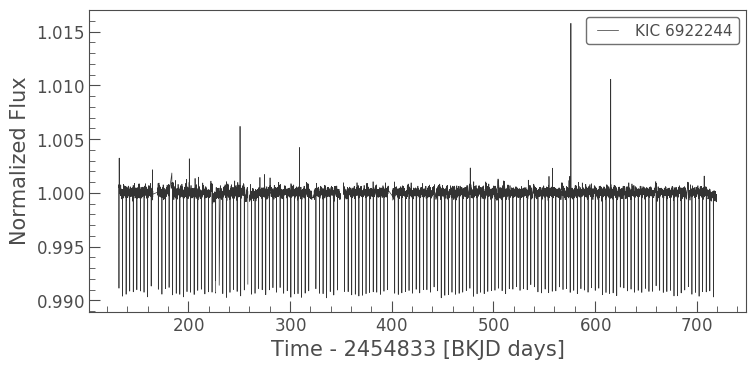

In [55]:
lc.plot()

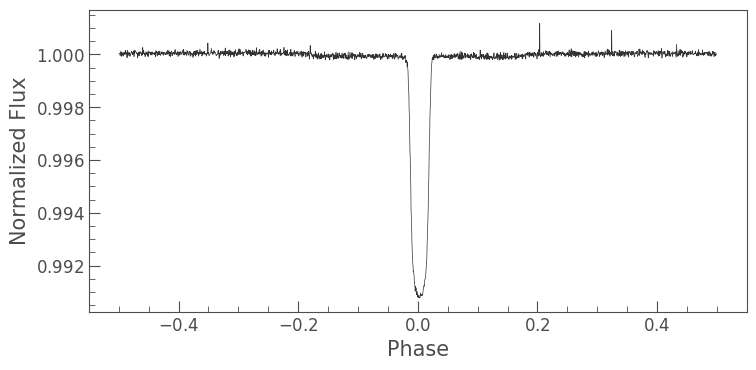

In [57]:
lc.fold(3.52254, phase=0.38).bin().plot()

Notes:
- Plots are no longer scatter in newest version of lightkurve?
- Window length of the flatten() method risks imposing systematics if its not set manually. Why?

# Interactively inspecting TPFs and LCs

In [58]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(249928278, campaign=15)

In [64]:
tpf.interact(notebook_url='localhost:8889')